In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import os
import csv
import copy
import json
import logging
from dataclasses import dataclass, field
from typing import Optional, Dict, Sequence, Tuple, List
import matplotlib.pyplot as plt
from scipy.stats import entropy

import torch
import torch.nn as nn
import transformers
from transformers import Trainer, TrainingArguments
from transformers import TrainerCallback
import sklearn
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from scipy.special import softmax
from peft import (
    LoraConfig,
    AdaLoraConfig,
    get_peft_model,
    get_peft_model_state_dict,
    AdaLoraModel
)

import torch.nn.functional as F
import matplotlib as mpl
torch.manual_seed(0)
np.random.seed(0)

/common/zhanh/anaconda3/envs/dna_gpn/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
@dataclass
class TrainingArguments(transformers.TrainingArguments):
    cache_dir: Optional[str] = field(default=None)
    run_name: str = field(default="run")
    optim: str = field(default="adamw_torch")
    model_max_length: int = field(default=1024, metadata={"help": "Maximum sequence length."})
    gradient_accumulation_steps: int = field(default=1)
    per_device_train_batch_size: int = field(default=1)
    per_device_eval_batch_size: int = field(default=1)
    num_train_epochs: int = field(default=10)
    fp16: bool = field(default=False)
    logging_steps: int = field(default=100)
    save_steps: int = field(default=50)
    eval_steps: int = field(default=50)
    evaluation_strategy: str = field(default="steps")
    load_best_model_at_end: bool = field(default=True)     # load the best model when finished training (default metric is loss)
    metric_for_best_model: str = field(default="eval_loss") # the metric to use to compare models
    greater_is_better: bool = field(default=False)           # whether the `metric_for_best_model` should be maximized or not
    logging_strategy: str = field(default="steps")  # Log every "steps"
    logging_steps: int = field(default=50)  # Log every 100 steps
    warmup_ratio: int = field(default=0.1)
    weight_decay: float = field(default=1e-2)
    learning_rate: float = field(default=1e-5)
    lr_scheduler_type: str = field(default='linear')
    save_total_limit: int = field(default=10)
    load_best_model_at_end: bool = field(default=True)
    output_dir: str = field(default="/common/zhangz2lab/zhanh/esm-variants/output_0831/output")
    find_unused_parameters: bool = field(default=False)
    checkpointing: bool = field(default=False)
    dataloader_pin_memory: bool = field(default=False)
    eval_and_save_results: bool = field(default=True)
    save_model: bool = field(default=False)
    seed: int = field(default=42)
    logging_first_step: bool = field(default=True)
    early_stopping_patience: int = field(default = 5)  # number of evaluations without improvement to wait
    early_stopping_threshold: float = field(default = 1e-3)  # threshold for an improvement
training_args = TrainingArguments()

In [4]:
@dataclass
class ModelArguments:
    #model_name_or_path: Optional[str] = field(default="bert-base-uncased")
    model_name_or_path: Optional[str] = field(default="facebook/esm1b_t33_650M_UR50S")
    #model_name_or_path: Optional[str] = field(default="facebook/esm2_t33_650M_UR50D")
model_args = ModelArguments()

In [5]:
class CustomCallback(TrainerCallback):
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        self.step_count = 0
        self.alphabet = {'<cls>': 0, '<pad>': 1, '<eos>': 2, '<unk>': 3, 'L': 4, 'A': 5, 'G': 6, 'V': 7, 'S': 8, 'E': 9, 'R': 10, 'T': 11, 'I': 12, 'D': 13, 'P': 14, 'K': 15, 'Q': 16, 'N': 17, 'F': 18, 'Y': 19, 'M': 20, 'H': 21, 'W': 22, 'C': 23, 'X': 24, 'B': 25, 'U': 26, 'Z': 27, 'O': 28, '.': 29, '-': 30, '<null_1>': 31, '<mask>': 32}

    def compute_pll_for_sequence(self, sequence, model):
        #tokens = self.tokenizer(sequence, return_tensors="pt", padding=True, truncation=True)
        tokens = self.tokenizer(sequence, return_tensors="pt", truncation=True, padding="max_length", max_length=training_args.model_max_length)
        model_device = next(model.parameters()).device
        for key in tokens.keys():
            tokens[key] = tokens[key].to(model_device)
            
        with torch.no_grad():
            outputs = model.base_model(input_ids=tokens['input_ids'], attention_mask=tokens['attention_mask'])
        
        logits = torch.log_softmax(outputs.logits, dim=-1)
        #print('logits',logits)
        idx = [self.alphabet[t] for t in sequence]
        PLL = torch.sum(torch.diag(logits[0, 1:-1, :][:, idx]))
        return PLL.item()

    def on_step_end(self, args, state, control, model=None, **kwargs):
        self.step_count += 1
        if self.step_count in [1,100, 350, 550]:  # Example values
            self.save_model(model, f"/common/zhangz2lab/zhanh/esm-variants/cm_model_step_{self.step_count}.pth")
        if self.step_count == 1 or self.step_count % 50 == 0:  # You can adjust the frequency as needed.
            all_sequences = []
            df = pd.read_csv("/common/zhangz2lab/zhanh/esm-variants/cropped/cm_test_data_1024.csv")
            all_sequences = df['wt_seq'].tolist()

            all_plls_wt = []
            for seq in all_sequences:
                wt_pll = self.compute_pll_for_sequence(seq, model)
                all_plls_wt.append(wt_pll)

            #print(f"Step {self.step_count}: Pseudo-Log-Likelihoods for all sequences: {all_plls_wt}")
            #logging.info(f"Step {self.step_count}: Pseudo-Log-Likelihoods for all sequences: {all_plls_wt}")
            
            all_sequences = []
            all_sequences = df['mut_seq'].tolist()

            all_plls_mut = []
            for seq in all_sequences:
                mut_pll = self.compute_pll_for_sequence(seq, model)
                all_plls_mut.append(mut_pll)

            all_plls_wt = np.array(all_plls_wt)
            all_plls_mut = np.array(all_plls_mut)
        
        # Compute the PLLR
            PLLR_callback = np.abs(all_plls_wt - all_plls_mut)
        
        # Get true labels
            true_labels_callback = df['labels'].to_numpy()
            
            benign_pllr = PLLR_callback[true_labels_callback == 0]
            pathogenic_pllr = PLLR_callback[true_labels_callback == 1]

            # Create a distribution plot
            plt.figure(figsize=(10, 6))
            sns.kdeplot(benign_pllr, shade=True, label="Benign")
            plt.title('Distribution of PLLR values by label')
            plt.xlabel('PLLR Value')
            plt.ylabel('Density')
            plt.legend()

            plt.show()

        # Compute AUC and AUPR
            fpr, tpr, _ = roc_curve(true_labels_callback, PLLR_callback)
            roc_auc = auc(fpr, tpr)
            aupr = average_precision_score(true_labels_callback, PLLR_callback)
            
            plt.figure()
            lw = 2  # line width
            plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
            plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic (ROC) for PLLR')
            plt.legend(loc="lower right")
            plt.show()
        
        # Logging
            #print(f"Step {self.step_count}: Pseudo-Log-Likelihoods for wt sequences: {all_plls_wt}")
            #print(f"Step {self.step_count}: Pseudo-Log-Likelihoods for mut sequences: {all_plls_mut}")
            logging.info(f"Step {self.step_count}: Pseudo-Log-Likelihoods for wt sequences: {all_plls_wt}")
            logging.info(f"Step {self.step_count}: Pseudo-Log-Likelihoods for mut sequences: {all_plls_mut}")
            print(f"AUC: {roc_auc}")
            print(f"Area Under the Precision-Recall Curve (AUPR): {aupr}")

In [6]:
class CustomCallback(TrainerCallback):
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        self.step_count = 0
        self.alphabet = {'<cls>': 0, '<pad>': 1, '<eos>': 2, '<unk>': 3, 'L': 4, 'A': 5, 'G': 6, 'V': 7, 'S': 8, 'E': 9, 'R': 10, 'T': 11, 'I': 12, 'D': 13, 'P': 14, 'K': 15, 'Q': 16, 'N': 17, 'F': 18, 'Y': 19, 'M': 20, 'H': 21, 'W': 22, 'C': 23, 'X': 24, 'B': 25, 'U': 26, 'Z': 27, 'O': 28, '.': 29, '-': 30, '<null_1>': 31, '<mask>': 32}

    def compute_pll_for_sequence(self, sequence, model):
        #tokens = self.tokenizer(sequence, return_tensors="pt", padding=True, truncation=True)
        tokens = self.tokenizer(sequence, return_tensors="pt", truncation=True, padding="max_length", max_length=training_args.model_max_length)
        model_device = next(model.parameters()).device
        for key in tokens.keys():
            tokens[key] = tokens[key].to(model_device)
            
        with torch.no_grad():
            outputs = model.base_model(input_ids=tokens['input_ids'], attention_mask=tokens['attention_mask'])
        
        logits = torch.log_softmax(outputs.logits, dim=-1)
        #print('logits',logits)
        idx = [self.alphabet[t] for t in sequence]
        PLL = torch.sum(torch.diag(logits[0, 1:-1, :][:, idx]))
        return PLL.item(), logits
    
    def create_directory(self, step):
        base_dir = "/common/zhangz2lab/zhanh/esm-variants/output_1004/cm/"
        dir_name = os.path.join(base_dir, f"step_{step}_logs")
        os.makedirs(dir_name, exist_ok=True)  # Create the directory if it doesn't exist
        return dir_name
    
    def save_model(self, model, path):
        torch.save(model.state_dict(), path) 

    def on_step_end(self, args, state, control, model=None, **kwargs):
        self.step_count += 1
        #if self.step_count in [1,100, 350, 550, 800]:  # Example values
            #self.save_model(model, f"/common/zhangz2lab/zhanh/esm-variants/cm_model_PLLR_test_step_{self.step_count}.pth")
        if self.step_count == 1 or self.step_count % 50 == 0:  # You can adjust the frequency as needed.
            current_dir = self.create_directory(self.step_count)
            all_sequences = []
            df = pd.read_csv("/common/zhangz2lab/zhanh/esm-variants/cropped/Clinvar_CM_protein.csv")
            all_sequences = df['wt_seq'].tolist()
            df_arm = pd.read_csv("/common/zhangz2lab/zhanh/esm-variants/cropped/arm_test_data_1024.csv")
            sequence_arm = df_arm['wt_seq'].iloc[0]

            all_plls_wt = []
            all_plls_wt_weighted = []
            index = 0
            
            _, arm_wt_logits = self.compute_pll_for_sequence(sequence_arm, model)
            logit_df_arm = pd.DataFrame(arm_wt_logits[0].cpu().numpy())
            logit_df_arm.to_csv(f"{current_dir}/logit_arm.csv", index=False)
            
            for seq in all_sequences:
                wt_pll, wt_logits = self.compute_pll_for_sequence(seq, model)
                all_plls_wt.append(wt_pll)
                all_plls_wt_weighted.append(wt_pll / len(seq))
                index = index + 1
                logit_df = pd.DataFrame(wt_logits[0].cpu().numpy())
                logit_df.to_csv(f"{current_dir}/logit_{index}.csv", index=False)

            #print(f"Step {self.step_count}: Pseudo-Log-Likelihoods for all sequences: {all_plls_wt}")
            #logging.info(f"Step {self.step_count}: Pseudo-Log-Likelihoods for all sequences: {all_plls_wt}")
            
            all_sequences = []
            all_sequences = df['mut_seq'].tolist()

            all_plls_mut = []
            all_plls_mut_weighted = []
            for seq in all_sequences:
                mut_pll, _ = self.compute_pll_for_sequence(seq, model)
                all_plls_mut.append(mut_pll)
                all_plls_mut_weighted.append(mut_pll / len(seq))

            all_plls_wt = np.array(all_plls_wt)
            all_plls_mut = np.array(all_plls_mut)
            
            all_plls_wt_weighted = np.array(all_plls_wt_weighted)
            all_plls_mut_weighted = np.array(all_plls_mut_weighted)
        
        # Compute the PLLR
            PLLR_callback = np.abs(all_plls_wt - all_plls_mut)
            PLLR_weighted_callback = np.abs(all_plls_wt_weighted - all_plls_mut_weighted)
        
        # Get true labels
            true_labels_callback = df['labels'].to_numpy()
            
#             plt.figure(figsize=(12, 5))
#             mpl.rcParams['font.size'] = 18
#             if self.step_count == 1:
#                 # [your code to get benign_pllr and pathogenic_pllr for zero-shot]
#                 self.benign_pllr_zeroshot = PLLR_callback[true_labels_callback == 0]
#                 self.pathogenic_pllr_zeroshot = PLLR_callback[true_labels_callback == 1]

#                 hist_benign_zeroshot, self.bin_edges = np.histogram(self.benign_pllr_zeroshot, bins=100, density=True)
#                 hist_pathogenic_zeroshot, _ = np.histogram(self.pathogenic_pllr_zeroshot, bins=self.bin_edges, density=True)
#                 hist_benign_zeroshot += 1e-10
#                 hist_pathogenic_zeroshot += 1e-10
#                 self.kl_div_zeroshot = entropy(hist_benign_zeroshot, hist_pathogenic_zeroshot)

#             if self.step_count % 50 == 0 or self.step_count == 1:
#                 # [your code to get benign_pllr and pathogenic_pllr for fine-tuned]
#                 benign_pllr_finetuned = PLLR_callback[true_labels_callback == 0]
#                 pathogenic_pllr_finetuned = PLLR_callback[true_labels_callback == 1]

#                 hist_benign_finetuned, _ = np.histogram(benign_pllr_finetuned, bins=self.bin_edges, density=True)
#                 hist_pathogenic_finetuned, _ = np.histogram(pathogenic_pllr_finetuned, bins=self.bin_edges, density=True)
#                 hist_benign_finetuned += 1e-10
#                 hist_pathogenic_finetuned += 1e-10
#                 kl_div_finetuned = entropy(hist_benign_finetuned, hist_pathogenic_finetuned)

#                 # Plot
#                 sns.kdeplot(self.benign_pllr_zeroshot, shade=True, label="zero-shot benign")
#                 sns.kdeplot(self.pathogenic_pllr_zeroshot, shade=True, label="zero-shot pathogenic")
#                 sns.kdeplot(benign_pllr_finetuned, shade=True, label="fine-tuned benign")
#                 sns.kdeplot(pathogenic_pllr_finetuned, shade=True, label="fine-tuned pathogenic")

#                 # Title, labels, and annotation
#                 plt.title('Distribution of PLLR values by label')
#                 plt.xlabel('PLLR Value')
#                 plt.ylabel('Density')
#                 plt.legend()
#                 plt.annotate(f"KL-Divergence (zero-shot): {self.kl_div_zeroshot:.4f}", xy=(0.5, 0.1), xycoords="axes fraction", fontsize=18)
#                 plt.annotate(f"KL-Divergence (fine-tuned): {kl_div_finetuned+10:.4f}", xy=(0.5, 0.05), xycoords="axes fraction", fontsize=18)

#                 plt.show()
            
            # Compute metrics for PLLR_callback
            fpr, tpr, _ = roc_curve(true_labels_callback, PLLR_callback)
            roc_auc = auc(fpr, tpr)
            aupr = average_precision_score(true_labels_callback, PLLR_callback)

            # Compute metrics for PLLR_weighted_callback
            fpr_weighted, tpr_weighted, _ = roc_curve(true_labels_callback, PLLR_weighted_callback)
            roc_auc_weighted = auc(fpr_weighted, tpr_weighted)
            aupr_weighted = average_precision_score(true_labels_callback, PLLR_weighted_callback)

            # Plotting ROC for both PLLR_callback and PLLR_weighted_callback
            #plt.figure()
            plt.figure(figsize=(10, 7))
            mpl.rcParams['font.size'] = 18
            lw = 2  # line width
            plt.plot(fpr, tpr, color='darkorange', lw=lw, label='PLLR ROC curve (area = %0.2f)' % roc_auc)
            plt.plot(fpr_weighted, tpr_weighted, color='darkgreen', lw=lw, label='weighted PLLR ROC curve (area = %0.2f)' % roc_auc_weighted)
            plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic (ROC) for PLLR and weighted PLLR')
            plt.legend(loc="lower right")
            plt.show()

            # Plotting AUPR for both PLLR_callback and PLLR_weighted_callback
            precision, recall, _ = precision_recall_curve(true_labels_callback, PLLR_callback)
            precision_weighted, recall_weighted, _ = precision_recall_curve(true_labels_callback, PLLR_weighted_callback)

            no_skill = sum(true_labels_callback) / len(true_labels_callback)

            #plt.figure()
            plt.figure(figsize=(10, 7))
            mpl.rcParams['font.size'] = 18
            plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='navy')
            plt.plot(recall, precision, color='darkorange', lw=lw, label='PLLR PR curve (area = %0.2f)' % aupr)
            plt.plot(recall_weighted, precision_weighted, color='darkgreen', lw=lw, label='weighted PLLR PR curve (area = %0.2f)' % aupr_weighted)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title('Precision-Recall curve for PLLR and weighted PLLR')
            plt.legend()
            plt.show()

        
        # Logging
            #print(f"Step {self.step_count}: Pseudo-Log-Likelihoods for wt sequences: {all_plls_wt}")
            #print(f"Step {self.step_count}: Pseudo-Log-Likelihoods for mut sequences: {all_plls_mut}")
            logging.info(f"Step {self.step_count}: Pseudo-Log-Likelihoods for wt sequences: {all_plls_wt}")
            logging.info(f"Step {self.step_count}: Pseudo-Log-Likelihoods for mut sequences: {all_plls_mut}")
            print(f"AUC: {roc_auc}")
            print(f"Area Under the Precision-Recall Curve (AUPR): {aupr}")

In [7]:
# Dataset Definition
class SiameseDataset(Dataset):
    def __init__(self, tokenizer, filename):
        data = pd.read_csv(filename)
        self.tokenizer = tokenizer
        # Generating some random sequences for demonstration purposes
        #self.seq_a = ["AGTCCGTA" * 10 for _ in range(num_examples)]
        #self.seq_b = ["TCGATCGA" * 10 for _ in range(num_examples)]
        #self.labels = [np.random.randint(0,2) for _ in range(num_examples)]  # Random binary labels
        self.seq_a = list(data['wt_seq'])
        self.seq_b = list(data['mut_seq'])
        self.labels = list(data['labels'])
        self.num_examples = len(self.labels)
    
    def __len__(self):
        return self.num_examples
    
    def __getitem__(self, idx):
        inputs_a = self.tokenizer(self.seq_a[idx], return_tensors="pt", truncation=True, padding="max_length", max_length=training_args.model_max_length)
        inputs_b = self.tokenizer(self.seq_b[idx], return_tensors="pt", truncation=True, padding="max_length", max_length=training_args.model_max_length)
        
        return {
            "input_ids1": inputs_a["input_ids"].squeeze(0), 
            "attention_mask1": inputs_a["attention_mask"].squeeze(0),
            "input_ids2": inputs_b["input_ids"].squeeze(0),
            "attention_mask2": inputs_b["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }
    
#         inputs_a = self.tokenizer(self.seq_a[idx], max_length=training_args.model_max_length)
#         inputs_b = self.tokenizer(self.seq_b[idx], max_length=training_args.model_max_length)
        
#         input_ids1 = torch.tensor(inputs_a["input_ids"]).squeeze(0) if isinstance(inputs_a["input_ids"], list) else inputs_a["input_ids"].squeeze(0)
#         attention_mask1 = torch.tensor(inputs_a["attention_mask"]).squeeze(0) if isinstance(inputs_a["attention_mask"], list) else inputs_a["attention_mask"].squeeze(0)
    
#         input_ids2 = torch.tensor(inputs_b["input_ids"]).squeeze(0) if isinstance(inputs_b["input_ids"], list) else inputs_b["input_ids"].squeeze(0)
#         attention_mask2 = torch.tensor(inputs_b["attention_mask"]).squeeze(0) if isinstance(inputs_b["attention_mask"], list) else inputs_b["attention_mask"].squeeze(0)
        

In [8]:
class SiameseNetwork(nn.Module):
    def __init__(self, model_name_or_path, num_labels, cache_dir=None):
        super(SiameseNetwork, self).__init__()
        
        # Load the base model
        self.base_model = transformers.AutoModelForMaskedLM.from_pretrained(
            model_name_or_path,
            cache_dir=cache_dir,
            output_hidden_states = True
        )
        
        # Classification head
        #self.classifier = nn.Sequential(
        #    nn.Linear(self.base_model.config.hidden_size * 2, 128),
        #    nn.ReLU(),
        #    nn.Linear(128, num_labels)
        #)
        
    def forward(self, input_ids1, attention_mask1, input_ids2, attention_mask2, labels):
        # Encoding sequences using the same base model
        #output1 = self.base_model(input_ids=input_ids1, attention_mask=attention_mask1).last_hidden_state[:, 0, :]
        #output2 = self.base_model(input_ids=input_ids2, attention_mask=attention_mask2).last_hidden_state[:, 0, :]
        #print(self.base_model)
        outputs1 = self.base_model(input_ids=input_ids1, attention_mask=attention_mask1)
        #print("Shape of logits1:", outputs1.logits.shape)
        output1 = outputs1.hidden_states[-1][:, 0, :]

        outputs2 = self.base_model(input_ids=input_ids2, attention_mask=attention_mask2)
        #print("Shape of logits2:", outputs2.logits.shape)
        output2 = outputs2.hidden_states[-1][:, 0, :]

        #print("Shape of [CLS] 1:", output1.shape)
        #print("Shape of [CLS] 2:", output2.shape)
        
        logits1 = torch.log_softmax(outputs1.logits, dim=-1)
        logits2 = torch.log_softmax(outputs2.logits, dim=-1)
        #print('logits1',logits1)
        #print('logits2',logits2)
        batch_size = input_ids1.shape[0]
        
        
        PLLs1 = torch.zeros(batch_size, device=input_ids1.device)
        PLLs2 = torch.zeros(batch_size, device=input_ids2.device)

        for i in range(batch_size):
            idx1 = input_ids1[i, 1:-1]  # Excluding the special tokens <cls> and <eos>/<pad>
            PLLs1[i] = torch.sum(torch.diag(logits1[i, 1:-1, :][:, idx1]))
        for i in range(batch_size):
            idx2 = input_ids2[i, 1:-1]  # Excluding the special tokens <cls> and <eos>/<pad>
            PLLs2[i] = torch.sum(torch.diag(logits2[i, 1:-1, :][:, idx2]))
        PLLR = torch.abs(PLLs1 - PLLs2)
        #print(PLLR)
        PLLR_t = PLLs1 - PLLs2
        #print(PLLR_t)
    
        
        
        
        # Concatenating the outputs or a distance can be computed
        #combined_out = torch.cat((output1, output2), dim=1)
        # Classifying the combined outputs
        #logits = self.classifier(combined_out)
        #loss = F.cross_entropy(logits, labels)
        
        #return logits, loss
        # Compute cosine similarity between output1 and output2
        cosine_sim = F.cosine_similarity(output1, output2, dim=-1)
        
        target = torch.where(labels == 1, -torch.ones_like(cosine_sim), torch.ones_like(cosine_sim)).float()
        
        # Compute the loss between cosine similarity and the labels
        # Assuming labels are in the range [-1, 1], denoting similarity
        loss = F.mse_loss(cosine_sim, target)
        #print("Shape of PLLs:", PLLs1.shape)
        #print("Shape of cosine_sim:", cosine_sim.shape)
        #print("Shape of target:", target.shape)

        sigmoid_PLLR = torch.sigmoid(PLLR)
        pll_loss = F.binary_cross_entropy(2*sigmoid_PLLR-1, labels.float())
        
        #return (loss, cosine_sim)
        return (pll_loss, PLLR)


In [9]:
model = SiameseNetwork(model_args.model_name_or_path, num_labels=2)
data_path = "/common/zhangz2lab/zhanh/esm-variants/cropped/"

tokenizer = transformers.AutoTokenizer.from_pretrained(model_args.model_name_or_path, 
                                                       model_max_length=training_args.model_max_length,) 
                                                       #padding_side="right",
                                                       #use_fast=True,
                                                       #trust_remote_code=True)
# tokenizer = transformers.AutoTokenizer.from_pretrained(
#         model_name_or_path,
#         model_max_length=512,
#         padding_side="right",
#         use_fast=True,
#         trust_remote_code=True,
#     )
print("Tokenizer class:", tokenizer.__class__)
print("Tokenizer name:", tokenizer.__class__.__name__)
    
#train_dataset = SiameseDataset(tokenizer, 900)
#test_dataset = SiameseDataset(tokenizer, 100)
train_dataset = SiameseDataset(tokenizer, os.path.join(data_path, 'cm_train_data_1024.csv'))
test_dataset = SiameseDataset(tokenizer, os.path.join(data_path, 'cm_test_data_1024.csv'))
test_dataset = SiameseDataset(tokenizer, os.path.join(data_path, 'Clinvar_CM_protein.csv'))


Tokenizer class: <class 'transformers.models.esm.tokenization_esm.EsmTokenizer'>
Tokenizer name: EsmTokenizer


In [10]:
# # Multiple sequences
# sequence = "MKLWTA"
# encoded_sequence = tokenizer.encode(sequence, add_special_tokens=True)

# # Output as a list of token IDs
# print("Token IDs:", encoded_sequence)

# # Convert token IDs back to tokens
# tokens = tokenizer.convert_ids_to_tokens(encoded_sequence)
# print("Tokens:", tokens)

# # Multiple sequences
# sequences = ["MKLWTA", "GATCRY"]
# encoded_sequences = tokenizer.batch_encode_plus(sequences, add_special_tokens=True, padding=True)

# # Output as lists of token IDs
# print("Token IDs:", encoded_sequences['input_ids'])

# # Convert token IDs back to tokens for each sequence
# for i, ids in enumerate(encoded_sequences['input_ids']):
#     print(f"Tokens for sequence {i+1}: {tokenizer.convert_ids_to_tokens(ids)}")



# input_df = pd.read_csv('/common/zhanh/Cardioboost_protein_sequences/cm_train_protein_seq_df.csv')
# print(input_df.loc[0, 'Original_Protein_Sequence'])
# encoded_sequence1 = tokenizer.encode(input_df.loc[0, 'Original_Protein_Sequence'], add_special_tokens=True)

# # Output as a list of token IDs
# print("Token IDs:", encoded_sequence1,len(encoded_sequence1))

# # Convert token IDs back to tokens
# tokens1 = tokenizer.convert_ids_to_tokens(encoded_sequence1)
# print("Tokens:", tokens1)

# print(input_df.loc[0, 'Mutated_Protein_Sequence'])
# encoded_sequence2 = tokenizer.encode(input_df.loc[0, 'Mutated_Protein_Sequence'], add_special_tokens=True)

# # Output as a list of token IDs
# print("Token IDs:", encoded_sequence2,len(encoded_sequence2))

# # Convert token IDs back to tokens
# tokens2 = tokenizer.convert_ids_to_tokens(encoded_sequence2)
# print("Tokens:", tokens2)

# differences = []
# for i, (char1, char2) in enumerate(zip(encoded_sequence1, encoded_sequence2)):
#     if char1 != char2:
#         differences.append((i, char1, char2))

# print(f"Differences found at these positions: {differences}")

In [11]:
def compute_metrics(eval_pred):
    cosine_sims, labels = eval_pred
    mse = ((cosine_sims - labels)**2).mean()
    # Flip the sign of the cosine similarities because we want -1 for label 1 and 1 for label 0
    flipped_cosine_sims = -cosine_sims
    
    # Convert these flipped values to "probabilities" in [0, 1]
    probabilities = (flipped_cosine_sims + 1) / 2  # Now values are between 0 and 1

    # Make binary predictions based on a threshold (e.g., 0.7)
    predictions = (probabilities > 0.1).astype(np.int32)

    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    auc = roc_auc_score(labels, probabilities)
    return {
        'mse': mse,
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'auc': auc
    }

In [12]:
def compute_metrics_PLLR(eval_pred):
    PLLR, labels = eval_pred
    auc = roc_auc_score(labels, PLLR)
    aupr = average_precision_score(labels, PLLR)
    return {
        'auc': auc,
        'aupr':aupr
    }

In [13]:
# Define compute_metrics for evaluation
# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)
#     return {
#         'accuracy': (predictions == labels).mean()
#     }

def custom_data_collator(data):
    # Here, we ensure that each item in `data` has the necessary keys.
    input_ids1 = torch.stack([item['input_ids1'] for item in data])
    attention_mask1 = torch.stack([item['attention_mask1'] for item in data])
    input_ids2 = torch.stack([item['input_ids2'] for item in data])
    attention_mask2 = torch.stack([item['attention_mask2'] for item in data])

    # Ensure labels exist or handle its absence
    #labels = [item.get('labels', torch.tensor(-1)) for item in data]  # Using -1 as a default
    #labels = torch.stack(labels)
    labels = torch.stack([item['labels'] for item in data])

    return {
        'input_ids1': input_ids1,
        'attention_mask1': attention_mask1,
        'input_ids2': input_ids2,
        'attention_mask2': attention_mask2,
        'labels': labels
    }

custom_callback_instance = CustomCallback(tokenizer=tokenizer)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics_PLLR,
    data_collator=custom_data_collator,
    callbacks=[custom_callback_instance]
)



In [14]:
# Let's assume you've already loaded your trained model into a variable named `model`.

# Create tokens for your test sequences using your tokenizer.
# Assuming `tokenizer` is your tokenizer and `test_seq1` and `test_seq2` are your test sequences.
# Choose device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Move model to device
model.to(device)
df = pd.read_csv("/common/zhangz2lab/zhanh/esm-variants/cropped/cm_test_data_1024.csv")

# For simplicity, let's get the sequences of the first row in the CSV
wt_seq_full = df['wt_seq'].iloc[0]
mut_seq_full = df['mut_seq'].iloc[0]
start_pos = df['start_pos'].iloc[0]

# Extract sequences around start_pos
test_seq1 = wt_seq_full[max(0, start_pos - 9):start_pos + 9]
test_seq2 = mut_seq_full[max(0, start_pos - 9):start_pos + 9]
#test_seq1 = "LAGVER"
#test_seq2 = "<mask><mask><mask><mask><mask><mask>"
encoded_sequence = tokenizer.encode(test_seq1, add_special_tokens=True)

# # # Output as a list of token IDs
print("Token IDs:", encoded_sequence)
encoded_sequence = tokenizer.encode(test_seq2, add_special_tokens=True)

# # # Output as a list of token IDs
print("Token IDs:", encoded_sequence)
tokens1 = tokenizer(test_seq1, return_tensors="pt", truncation=True, padding="max_length", max_length=training_args.model_max_length)
tokens2 = tokenizer(test_seq2, return_tensors="pt", truncation=True, padding="max_length", max_length=training_args.model_max_length)  # Assuming test_seq2 contains mask tokens.
tokens1 = tokenizer(test_seq1, return_tensors="pt", truncation=True, padding=False)
tokens2 = tokenizer(test_seq2, return_tensors="pt", truncation=True, padding=False)  # Assuming test_seq2 contains mask tokens.
label = torch.tensor([1], dtype=torch.int64).to(device)

# # Move tensors to device
tokens1 = {k: v.to(device) for k, v in tokens1.items()}
tokens2 = {k: v.to(device) for k, v in tokens2.items()}

with torch.no_grad():
     outputs1 = model.base_model(input_ids=tokens1['input_ids'], attention_mask=tokens1['attention_mask'])
     output1 = outputs1.hidden_states[-1][:, 0, :]

     outputs2 = model.base_model(input_ids=tokens2['input_ids'], attention_mask=tokens2['attention_mask'])
     output2 = outputs2.hidden_states[-1][:, 0, :]

# # Examine the outputs
print("Output1 shape:", outputs1.logits.shape)
print("Output2 shape:", outputs2.logits.shape)

#logits = torch.log_softmax(outputs1.logits, dim=-1)
#s = logits[0][1:-1,:].shape
#alphabet = {'<cls>': 0, '<pad>': 1, '<eos>': 2, '<unk>': 3, 'L': 4, 'A': 5, 'G': 6, 'V': 7, 'S': 8, 'E': 9, 'R': 10, 'T': 11, 'I': 12, 'D': 13, 'P': 14, 'K': 15, 'Q': 16, 'N': 17, 'F': 18, 'Y': 19, 'M': 20, 'H': 21, 'W': 22, 'C': 23, 'X': 24, 'B': 25, 'U': 26, 'Z': 27, 'O': 28, '.': 29, '-': 30, '<null_1>': 31, '<mask>': 32}
#idx = [alphabet[t] for t in test_seq1]
#PLL = torch.sum(torch.diag(logits[0, 1:-1, :][:, idx]))
            

Token IDs: [0, 14, 21, 12, 18, 8, 12, 8, 13, 17, 5, 19, 16, 19, 20, 4, 11, 13, 10, 9, 17, 16, 8, 12, 4, 12, 11, 6, 9, 8, 6, 5, 6, 15, 11, 7, 17, 11, 15, 10, 7, 12, 16, 19, 18, 5, 7, 12, 5, 5, 12, 6, 13, 10, 8, 15, 15, 13, 16, 8, 14, 6, 15, 6, 11, 4, 9, 13, 16, 12, 12, 16, 5, 17, 14, 5, 4, 9, 5, 18, 6, 17, 5, 15, 11, 7, 10, 17, 13, 17, 8, 8, 10, 18, 6, 15, 18, 12, 10, 12, 21, 18, 6, 5, 11, 6, 15, 4, 5, 8, 5, 13, 12, 9, 11, 19, 4, 4, 9, 15, 8, 10, 7, 12, 18, 16, 4, 15, 5, 9, 10, 13, 19, 21, 12, 18, 19, 16, 12, 4, 8, 17, 15, 15, 14, 9, 4, 4, 13, 20, 4, 4, 12, 11, 17, 17, 14, 19, 13, 19, 5, 18, 12, 8, 16, 6, 9, 11, 11, 7, 5, 8, 12, 13, 13, 5, 9, 9, 4, 20, 5, 11, 13, 17, 5, 18, 13, 7, 4, 6, 18, 11, 8, 9, 9, 15, 17, 8, 20, 19, 15, 4, 11, 6, 5, 12, 20, 21, 18, 6, 17, 20, 15, 18, 15, 4, 15, 16, 10, 9, 9, 16, 5, 9, 14, 13, 6, 11, 9, 9, 5, 13, 15, 8, 5, 19, 4, 20, 6, 4, 17, 8, 5, 13, 4, 4, 15, 6, 4, 23, 21, 14, 10, 7, 15, 7, 6, 17, 9, 19, 7, 11, 15, 6, 16, 17, 7, 16, 16, 7, 12, 19, 5, 11, 6, 5, 

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert logits to numpy arrays
logits1_np = outputs1.logits.squeeze(0).cpu().numpy()
logits2_np = outputs2.logits.squeeze(0).cpu().numpy()

# Define the sequence and dictionary for labeling
sequence_labels1 = list(test_seq1)
sequence_labels2 = list(test_seq2)
dictionary_labels = tokenizer.convert_ids_to_tokens(range(33))

# Visualize logits for test_seq1
plt.figure(figsize=(12.5, 5))
sns.heatmap(logits1_np, xticklabels=dictionary_labels, yticklabels=sequence_labels1, cmap="YlGnBu", cbar=False)
#plt.title("Logits for Test Sequence 1")
#plt.xlabel("Dictionary Tokens")
#plt.ylabel("Sequence Tokens")
plt.show()

# Visualize logits for test_seq2
plt.figure(figsize=(12.5, 5))
sns.heatmap(logits2_np, xticklabels=dictionary_labels, yticklabels=sequence_labels2, cmap="YlGnBu", cbar=False)
#plt.title("Logits for Test Sequence 2")
#plt.xlabel("Dictionary Tokens")
#plt.ylabel("Sequence Tokens")
plt.show()


ModuleNotFoundError: No module named 'seaborn'

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert logits to numpy arrays
logits1_np = outputs1.logits.squeeze(0).cpu().numpy()
logits2_np = outputs2.logits.squeeze(0).cpu().numpy()

# Define the sequence and dictionary for labeling
sequence_labels1 = list(test_seq1)
sequence_labels2 = list(test_seq2)
dictionary_labels = tokenizer.convert_ids_to_tokens(range(33))

def draw_heatmap_with_highlighted_transitions(logits, sequence_labels, dictionary_labels, remove_xticks=False, rotate_xticks=False):
    plt.figure(figsize=(12.5, 5))
    ax = sns.heatmap(logits, xticklabels=dictionary_labels, yticklabels=sequence_labels, cmap="YlGnBu", cbar=False)
    
    # Highlight the predicted token probabilities with a red frame for each position
    for i, token in enumerate(sequence_labels):
        col = dictionary_labels.index(token)
        rect = plt.Rectangle((col, i), 1, 1, fill=False, edgecolor='red', lw=2)
        ax.add_patch(rect)
    
    # Compare and change y-tick label colors for different tokens
    for i, tick in enumerate(ax.get_yticklabels()):
        if sequence_labels1[i] != sequence_labels2[i]:  # Replace with correct comparison for your case
            tick.set_color('red')
            
    # Adjust x-ticks based on input flags
    if remove_xticks:
        ax.set_xticks([])
    elif rotate_xticks:
        ax.tick_params(axis='x', rotation=75)
    
    plt.show()

# Visualize logits for test_seq1
draw_heatmap_with_highlighted_transitions(logits1_np, sequence_labels1, dictionary_labels, remove_xticks=False, rotate_xticks=True)

# Visualize logits for test_seq2
draw_heatmap_with_highlighted_transitions(logits2_np, sequence_labels2, dictionary_labels, rotate_xticks=True)



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert logits to numpy arrays
logits1_np = outputs1.logits.squeeze(0).cpu().numpy()
logits2_np = outputs2.logits.squeeze(0).cpu().numpy()

# If the sequences already have the [CLS] token, then skip this step.
sequence_labels1 = ["<cls>"] + list(test_seq1)
sequence_labels2 = ["<cls>"] + list(test_seq2)
dictionary_labels = tokenizer.convert_ids_to_tokens(range(33))

def draw_heatmap_with_highlighted_transitions(logits, sequence_labels, dictionary_labels, rotate_xticks=False):
    plt.figure(figsize=(12.5, 5))
    ax = sns.heatmap(logits, xticklabels=dictionary_labels, yticklabels=sequence_labels, cmap="YlGnBu", cbar=True)
    
    # Highlight the predicted token probabilities with a red frame for each position
    for i, token in enumerate(sequence_labels):
        col = dictionary_labels.index(token)
        rect = plt.Rectangle((col, i), 1, 1, fill=False, edgecolor='red', lw=2)
        ax.add_patch(rect)
    
    for i, tick in enumerate(ax.get_yticklabels()):
        if sequence_labels1[i] != sequence_labels2[i]:  # Replace with correct comparison for your case
            tick.set_color('red')
    
    # Rotate x-axis labels if required
    if rotate_xticks:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.show()

# Visualize logits for test_seq1
draw_heatmap_with_highlighted_transitions(logits1_np, sequence_labels1, dictionary_labels)

# Visualize logits for test_seq2 with rotated x-axis labels
draw_heatmap_with_highlighted_transitions(logits2_np, sequence_labels2, dictionary_labels, rotate_xticks=True)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: zhanpython. Use `wandb login --relogin` to force relogin


{'eval_loss': 21.687532424926758, 'eval_auc': 0.7135358396504095, 'eval_aupr': 0.5913294934117705, 'eval_runtime': 418.067, 'eval_samples_per_second': 4.262, 'eval_steps_per_second': 4.262}


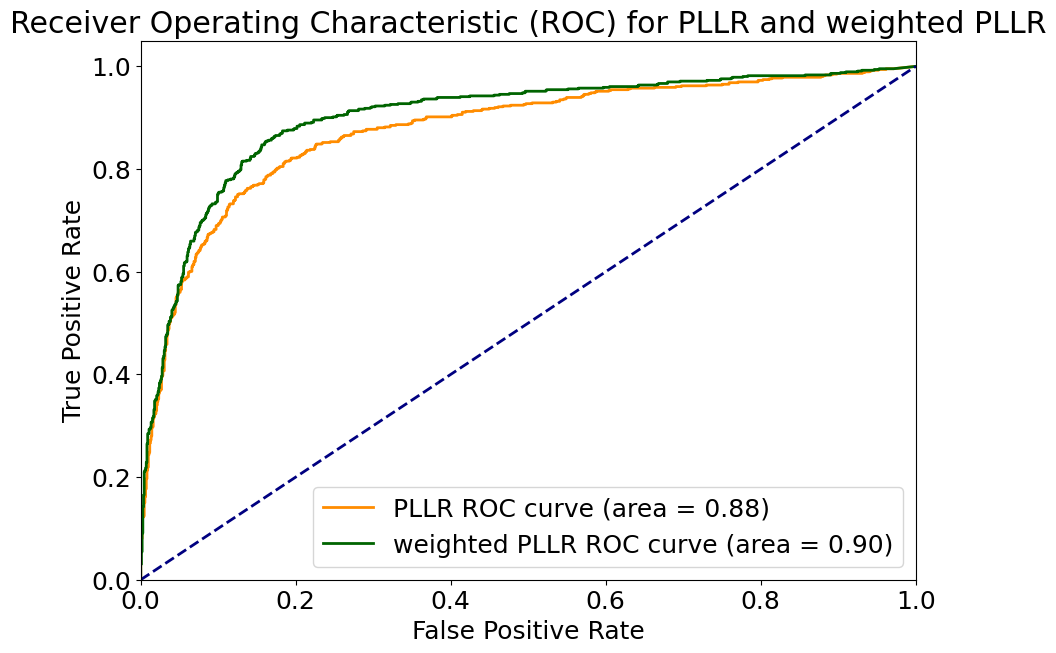

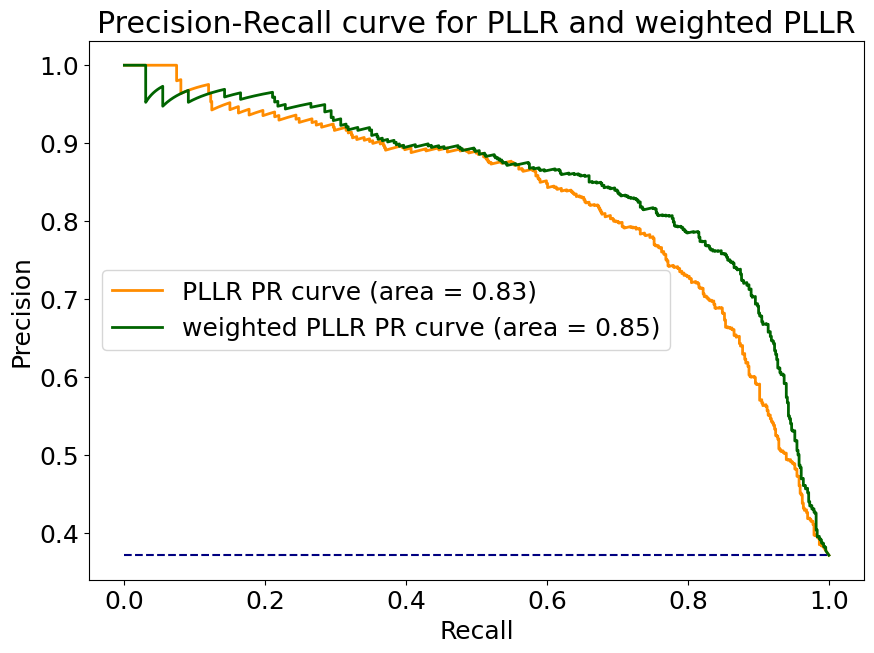

AUC: 0.8763443327156838
Area Under the Precision-Recall Curve (AUPR): 0.8277421471763362


Step,Training Loss,Validation Loss,Auc,Aupr
50,21.125700,21.844233,0.717610,0.593975
100,12.931000,21.901173,0.718294,0.595038
150,12.651400,22.239777,0.718689,0.564029
200,20.962200,19.166922,0.744233,0.577963
250,14.580500,18.531471,0.746199,0.579473


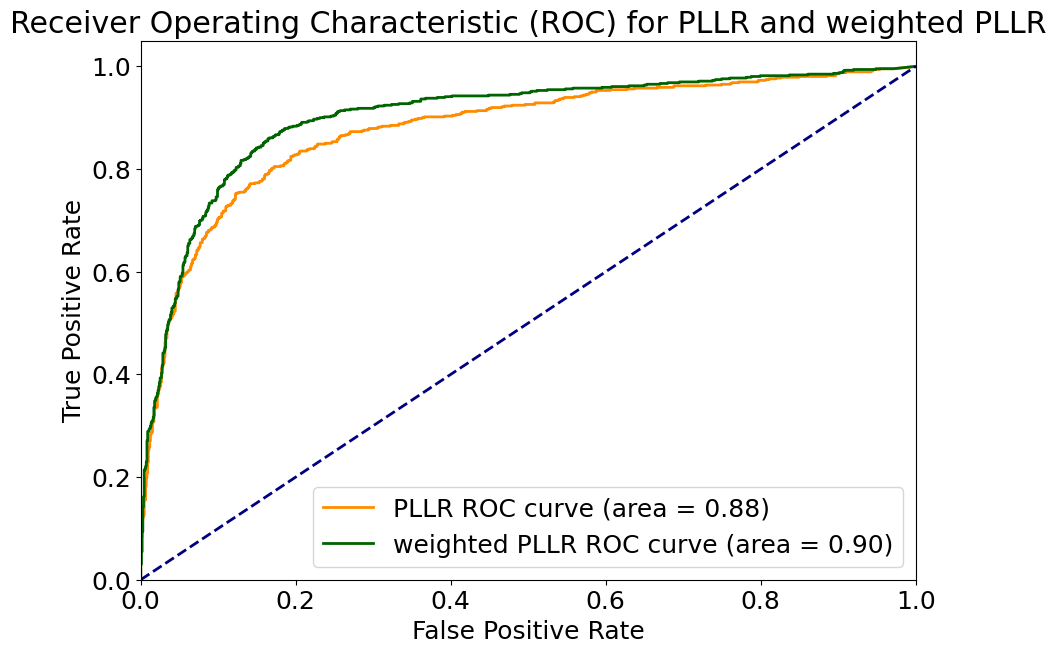

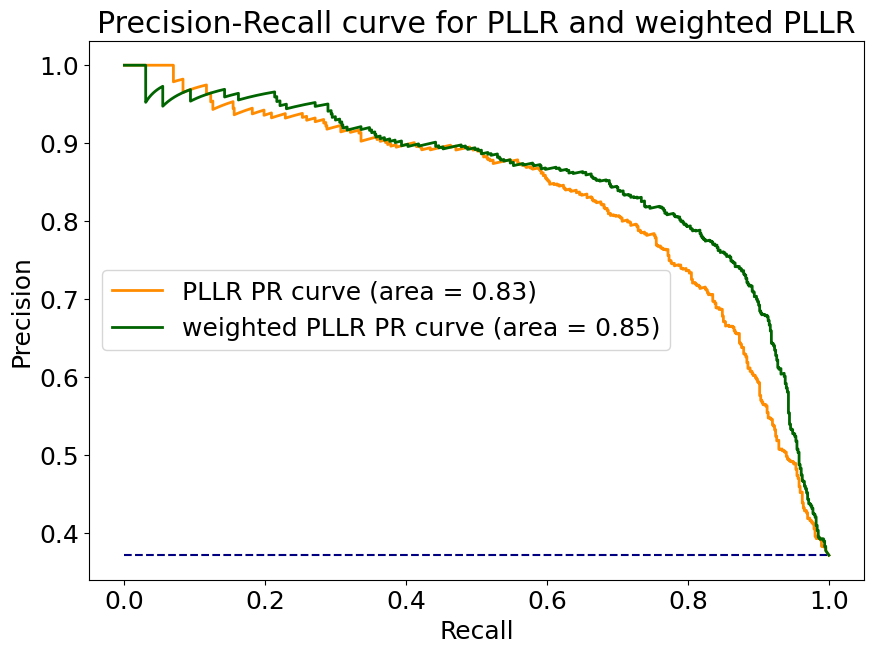

AUC: 0.877922645789838
Area Under the Precision-Recall Curve (AUPR): 0.830369472964356


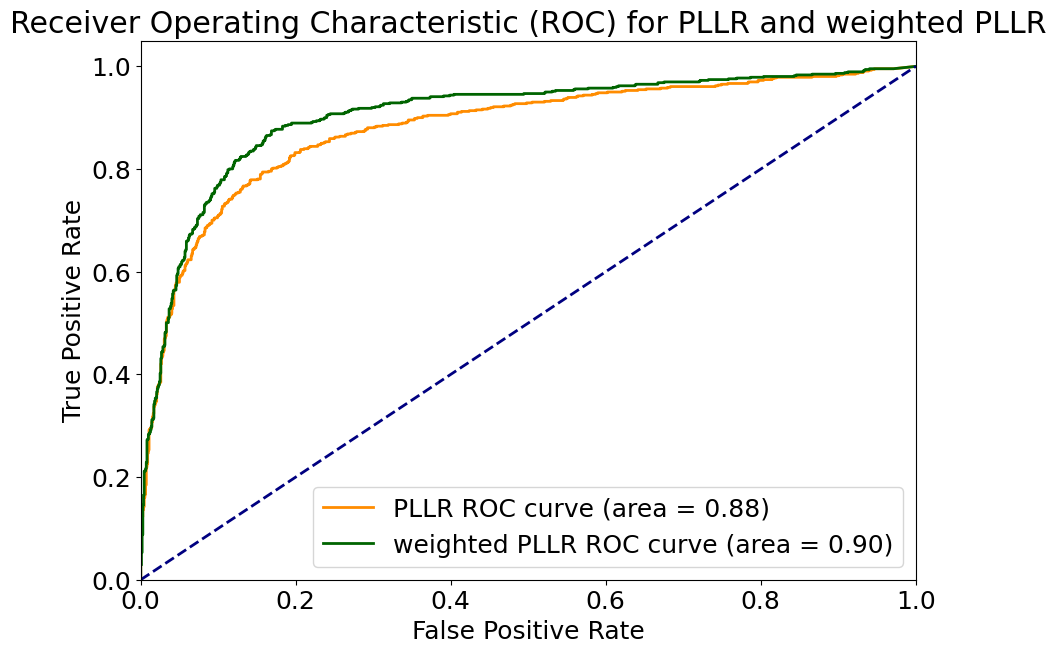

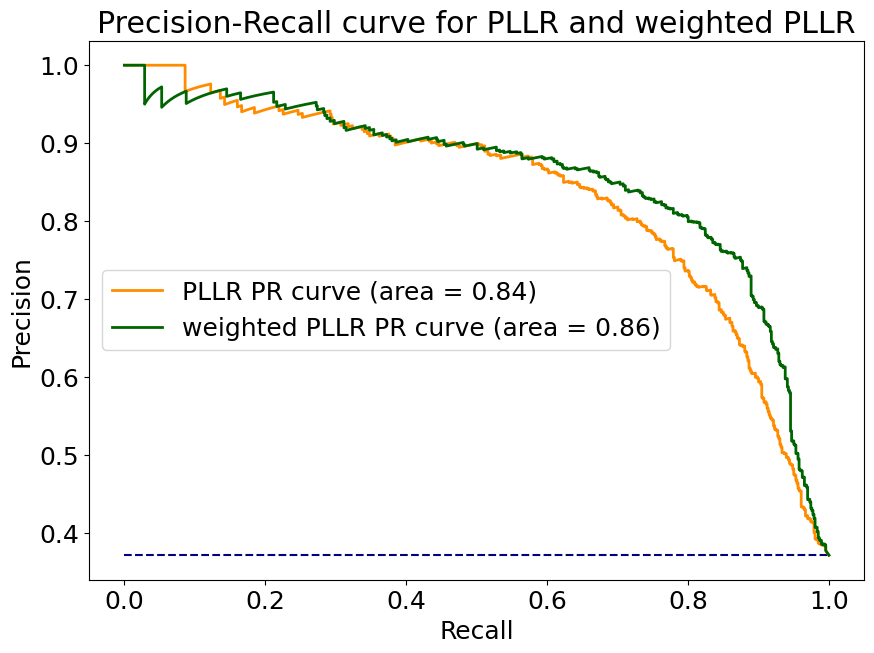

AUC: 0.8799247214166085
Area Under the Precision-Recall Curve (AUPR): 0.8360801525591064


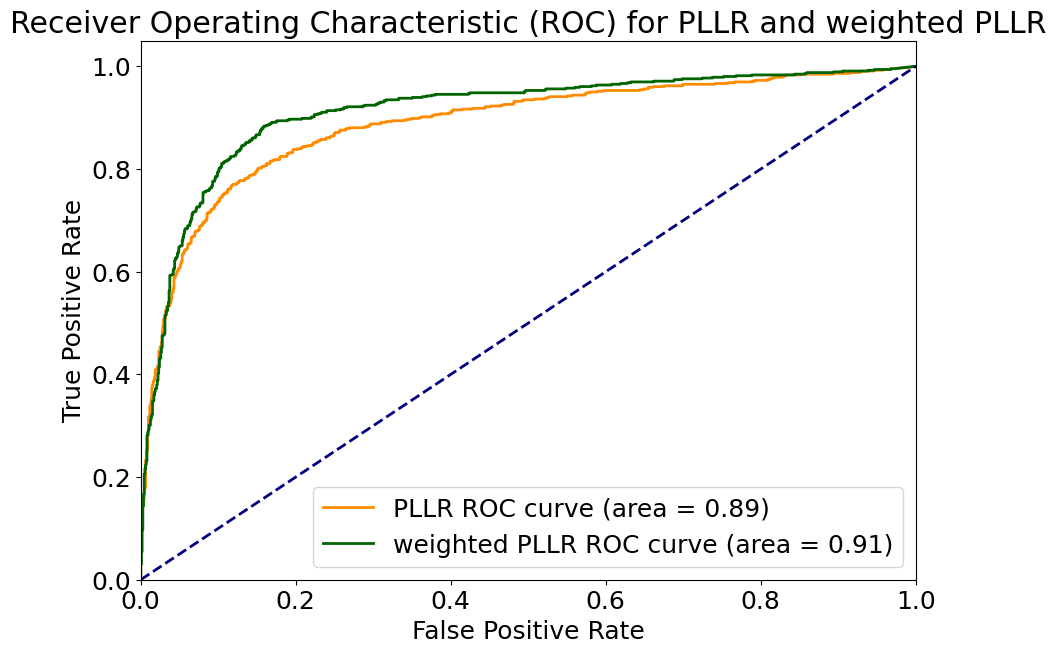

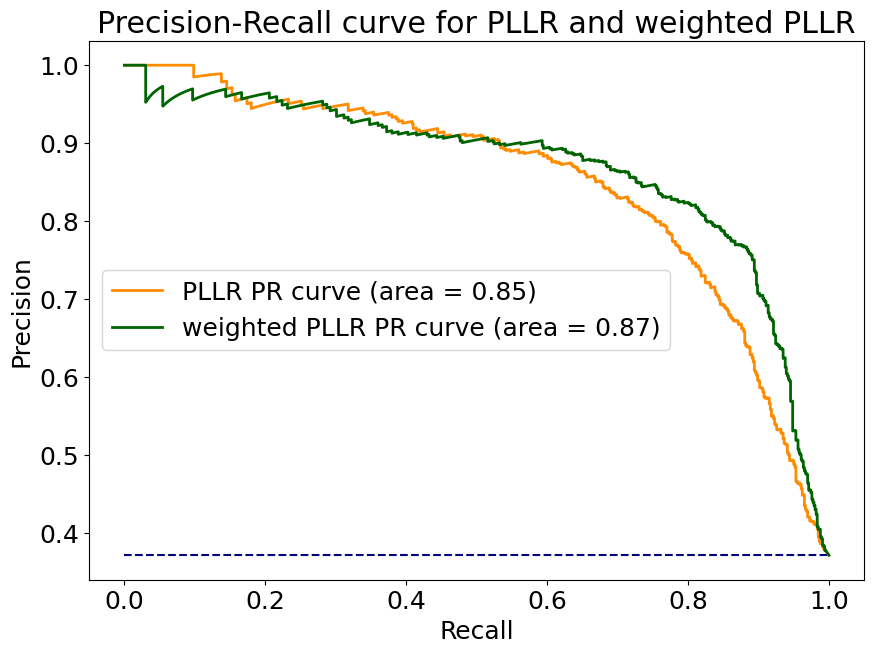

AUC: 0.8875328787107902
Area Under the Precision-Recall Curve (AUPR): 0.8500707705614208


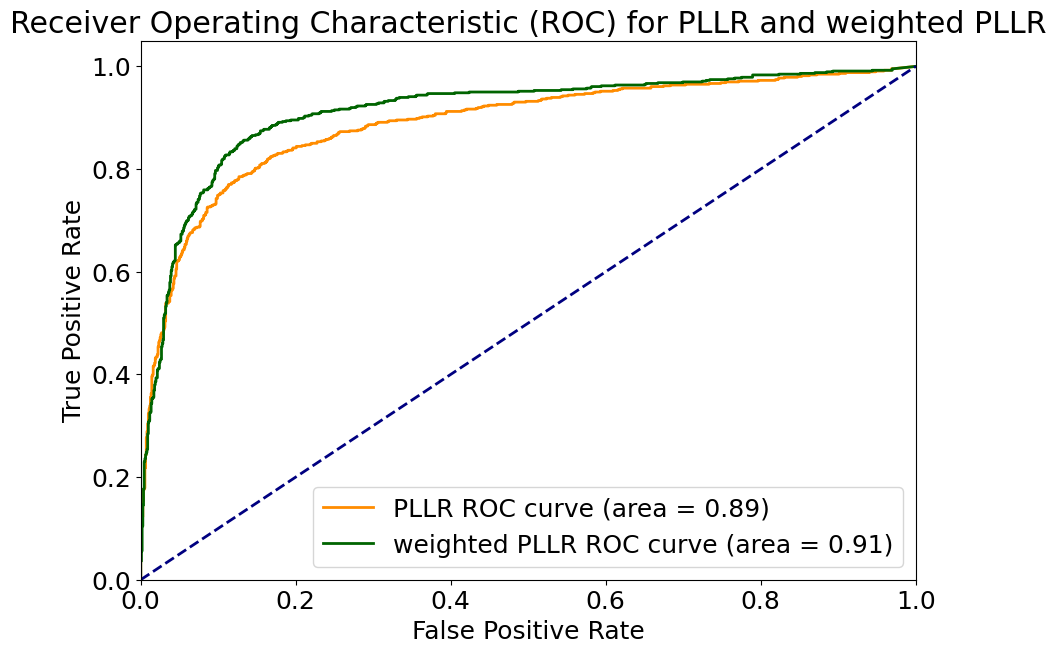

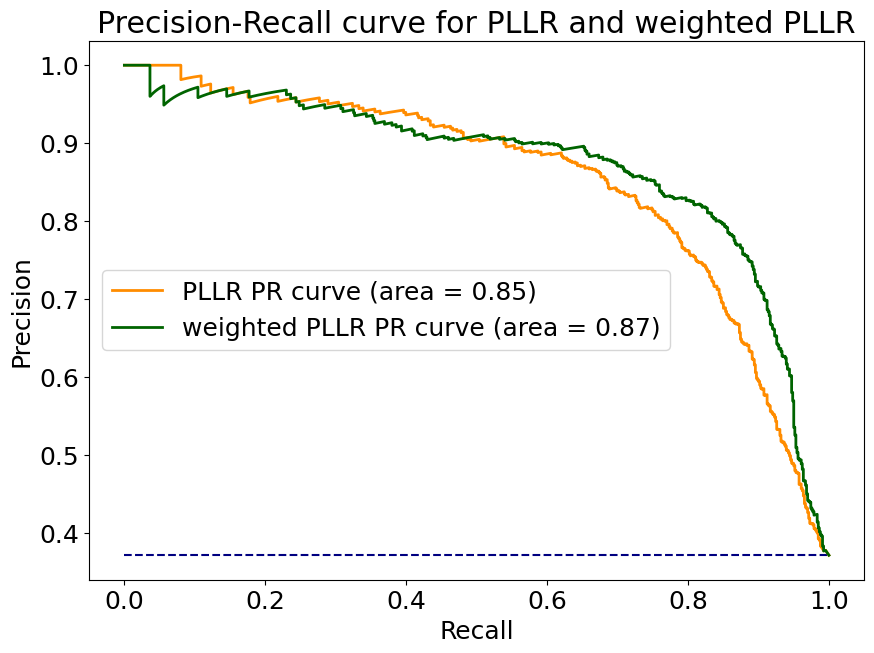

AUC: 0.889014698082677
Area Under the Precision-Recall Curve (AUPR): 0.8533061953359893


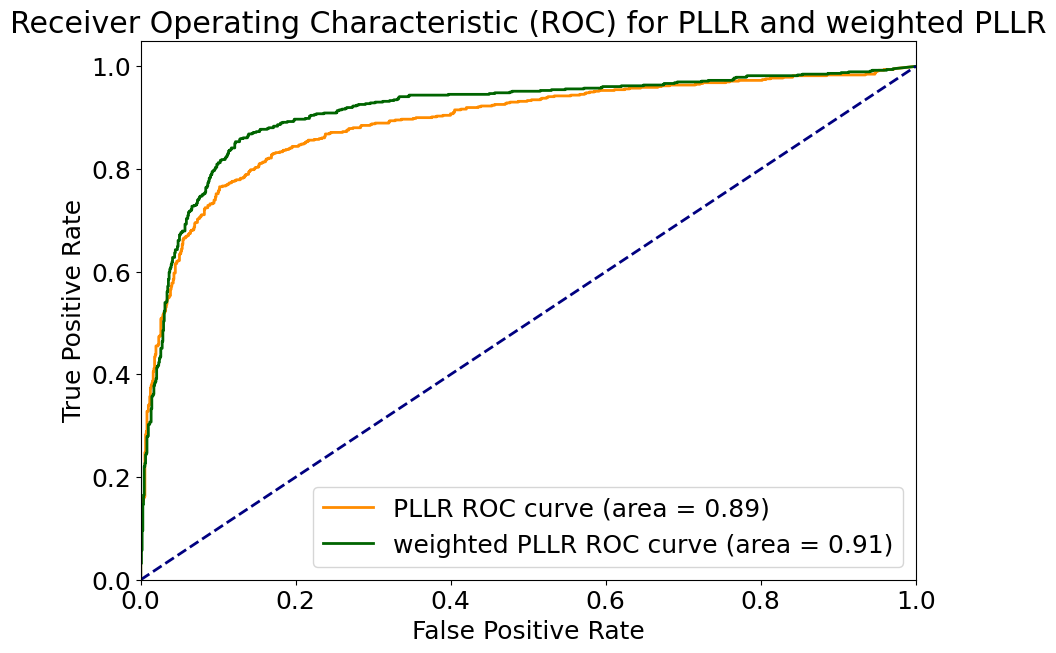

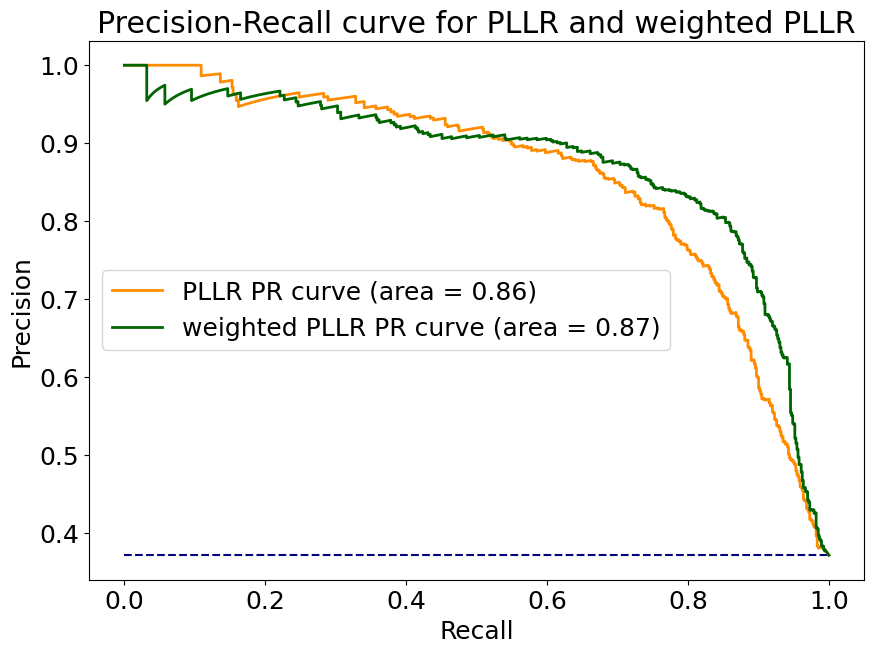

AUC: 0.8908494279880322
Area Under the Precision-Recall Curve (AUPR): 0.8576360962700544



KeyboardInterrupt



In [16]:
results = trainer.evaluate()
print(results)

# Training
trainer.train()


results = trainer.evaluate()
print(results)


In [ ]:
model = SiameseNetwork(model_args.model_name_or_path, num_labels=2)  # or however you initialize your model
model.load_state_dict(torch.load("/common/zhangz2lab/zhanh/esm-variants/cm_model_step_350.pth"))
model = model.cuda()
model.eval()  # Set the model to evaluation mode if needed
results = trainer.evaluate()
print(results)

In [ ]:
alphabet = {'<cls>': 0, '<pad>': 1, '<eos>': 2, '<unk>': 3, 'L': 4, 'A': 5, 'G': 6, 'V': 7, 'S': 8, 'E': 9, 'R': 10, 'T': 11, 'I': 12, 'D': 13, 'P': 14, 'K': 15, 'Q': 16, 'N': 17, 'F': 18, 'Y': 19, 'M': 20, 'H': 21, 'W': 22, 'C': 23, 'X': 24, 'B': 25, 'U': 26, 'Z': 27, 'O': 28, '.': 29, '-': 30, '<null_1>': 31, '<mask>': 32}
class ModelEvaluator:

    def __init__(self, model, tokenizer, alphabet):
        self.model = model
        self.tokenizer = tokenizer
        self.alphabet = alphabet

    def compute_pll_for_sequence(self, sequence):
        tokens = self.tokenizer(sequence, return_tensors="pt", truncation=True, padding="max_length", max_length=training_args.model_max_length)
        model_device = next(self.model.parameters()).device
        for key in tokens.keys():
            tokens[key] = tokens[key].to(model_device)  # This line essentially does the .cuda() operation

        with torch.no_grad():
            outputs = self.model.base_model(input_ids=tokens['input_ids'], attention_mask=tokens['attention_mask'])

        logits = torch.log_softmax(outputs.logits, dim=-1)
        idx = [self.alphabet[t] for t in sequence]
        PLL = torch.sum(torch.diag(logits[0, 1:-1, :][:, idx]))
        return PLL.item()

In [ ]:
class ModelEvaluator:

    def __init__(self, model, tokenizer, alphabet):
        self.model = model
        self.tokenizer = tokenizer
        self.alphabet = alphabet

    def compute_pll_for_sequence(self, sequence):
        tokens = self.tokenizer(sequence, return_tensors="pt", truncation=True, padding="max_length", max_length=training_args.model_max_length)
        model_device = next(self.model.parameters()).device
        for key in tokens.keys():
            tokens[key] = tokens[key].to(model_device)  # This line essentially does the .cuda() operation

        with torch.no_grad():
            outputs = self.model.base_model(input_ids=tokens['input_ids'], attention_mask=tokens['attention_mask'])

        logits = torch.log_softmax(outputs.logits, dim=-1)
        idx = [self.alphabet[t] for t in sequence]
        PLL = torch.sum(torch.diag(logits[0, 1:-1, :][:, idx]))
        return PLL.item()
    
    def compute_pll_for_token_id(self, token_ids, attention_mask):
        tokens = {
            'input_ids': torch.tensor([token_ids]).to(device), 
            'attention_mask': torch.tensor([attention_mask]).to(device)
        }
        model_device = next(self.model.parameters()).device
        for key in tokens.keys():
            tokens[key] = tokens[key].to(model_device)

        with torch.no_grad():
            outputs = self.model.base_model(input_ids=tokens['input_ids'], attention_mask=tokens['attention_mask'])

        logits = torch.log_softmax(outputs.logits, dim=-1)
        idx = token_ids[1:-1]  # Skip the first and the last token
        PLL = torch.sum(torch.diag(logits[0, 1:-1, :][:, idx]))
        return PLL.item()

In [ ]:
# Create an instance of the evaluator
evaluator = ModelEvaluator(model, tokenizer, alphabet)

# Load sequences
df = pd.read_csv("/common/zhangz2lab/zhanh/esm-variants/cropped/cm_test_data_1024.csv")
wt_sequences = df['wt_seq'].tolist()
mut_sequences = df['mut_seq'].tolist()

# Compute PLLs for wt sequences
all_plls_wt = [evaluator.compute_pll_for_sequence(seq) for seq in wt_sequences]

# Compute PLLs for mut sequences
all_plls_mut = [evaluator.compute_pll_for_sequence(seq) for seq in mut_sequences]

# Compute PLLR
PLLR_callback = np.abs(np.array(all_plls_wt) - np.array(all_plls_mut))
true_labels_callback = df['labels'].to_numpy()

# Compute AUC and AUPR
fpr, tpr, _ = roc_curve(true_labels_callback, PLLR_callback)
roc_auc = auc(fpr, tpr)
aupr = average_precision_score(true_labels_callback, PLLR_callback)

# Plotting the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for PLLR')
plt.legend(loc="lower right")
plt.show()

# Logging results
logging.info(f"Pseudo-Log-Likelihoods for wt sequences: {all_plls_wt}")
logging.info(f"Pseudo-Log-Likelihoods for mut sequences: {all_plls_mut}")
print(f"AUC: {roc_auc}")
print(f"Area Under the Precision-Recall Curve (AUPR): {aupr}")

In [ ]:
# Given the provided ModelEvaluator class and other code:

evaluator = ModelEvaluator(model, tokenizer, alphabet)

# Load sequences
df = pd.read_csv("/common/zhangz2lab/zhanh/esm-variants/cropped/cm_test_data_1024.csv")
wt_sequences = df['wt_seq'].tolist()
label= df['labels'].tolist()

def compute_pllr_for_sequence(sequence, evaluator):
    tokens = evaluator.tokenizer(sequence, return_tensors="pt", truncation=True, padding="max_length", max_length=training_args.model_max_length)
    original_pll = evaluator.compute_pll_for_sequence(sequence)
    tokenized_sequence = tokens['input_ids'][0].tolist()
    attention_mask = tokens['attention_mask'][0].tolist()
    
    pll_diffs = []

    with open('/common/zhangz2lab/zhanh/esm-variants/output_pllr/cm_pll_diffs_ft_1_p12883.csv', 'w') as csvfile:
        writer = csv.writer(csvfile)
        # Iterate over the tokenized sequence
        for i, token_id in enumerate(tokenized_sequence):
            pll_diff_row = []
            # For each token in the alphabet
            for replacement_token, replacement_id in evaluator.alphabet.items():
                if replacement_token not in ['<cls>', '<pad>', '<eos>', '<unk>']:
                    modified_token_sequence = tokenized_sequence[:i] + [replacement_id] + tokenized_sequence[i+1:]
                    modified_attention_mask = attention_mask.copy()

                    # Compute PLL using token indices directly
                    modified_pll = evaluator.compute_pll_for_token_id(modified_token_sequence, modified_attention_mask)
                    pll_diff = modified_pll - original_pll
                    pll_diff_row.append(pll_diff)

            pll_diffs.append(pll_diff_row)
            #print(pll_diff_row)
            writer.writerow(pll_diff_row)

    return pll_diffs


# Compute PLL differences for the second sequence in wt_sequences:
sequence_to_evaluate = wt_sequences[2]
print(wt_sequences[2])
print(label[2])
pllr_matrix = compute_pllr_for_sequence(sequence_to_evaluate, evaluator)

# Plotting the matrix as a heatmap:
plt.figure(figsize=(20, 20))
sns.heatmap(pllr_matrix, cmap="YlGnBu", cbar=True, xticklabels=list(evaluator.alphabet.keys()), yticklabels=list(sequence_to_evaluate))
plt.title('PLLR Heatmap')
plt.xlabel('Substitution Character')
plt.ylabel('Original Sequence')
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.mixture import GaussianMixture

plt.rcParams.update({'font.size': 20})

# Sample data: Assuming PLLR_callback and true_labels_callback are available
pathogenic_scores = PLLR_callback[true_labels_callback == 1]
benign_scores = PLLR_callback[true_labels_callback == 0]

# Create the figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting histograms (kde plots) for all scores, pathogenic, and benign
plt.hist(PLLR_callback, bins=50, color='gray', density=True, alpha=0.5, label='All sequences')
sns.kdeplot(pathogenic_scores, color='red', label='Pathogenic', ax=ax)
sns.kdeplot(benign_scores, color='blue', label='Benign', ax=ax)

# Fitting a Gaussian Mixture Model with 2 components
#gmm = GaussianMixture(n_components=5, init_params='random').fit(PLLR_callback.reshape(-1, 1))
#gmm = GaussianMixture(n_components=3, covariance_type='spherical').fit(PLLR_callback.reshape(-1, 1))
gmm = GaussianMixture(n_components=3, max_iter=500).fit(PLLR_callback.reshape(-1, 1))
print(gmm.converged_)

x = np.linspace(-5, max(PLLR_callback), 1000).reshape(-1, 1)
logprob = gmm.score_samples(x)
pdf = np.exp(logprob)
ax.plot(x, pdf, '-k', label="Gaussian mixture")

#gmm = GaussianMixture(n_components=5, max_iter=500, init_params='random').fit(PLLR_callback.reshape(-1, 1))
#print(gmm.converged_)



# Plotting the individual Gaussian distributions
#pdf_individual = gmm.predict_proba(x)
#pdf_individual = pdf_individual * pdf[:, np.newaxis]
#ax.plot(x, pdf_individual[:, 0], '-r', label="Component 1")
#ax.plot(x, pdf_individual[:, 1], '-g', label="Component 2")

# Labels and title
ax.set_xlabel('PLLR score')
ax.set_ylabel('Density')
ax.legend()
ax.set_title('Distribution of PLLRs')

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data: Assuming PLLR_callback and true_labels_callback are available
pathogenic_scores = PLLR_callback[true_labels_callback == 1]
benign_scores = PLLR_callback[true_labels_callback == 0]

# Combine scores and labels for plotting
all_scores = np.concatenate([pathogenic_scores, benign_scores])
labels = np.array(['Pathogenic'] * len(pathogenic_scores) + ['Benign'] * len(benign_scores))

# Create violin plots
plt.figure(figsize=(10, 6))
sns.violinplot(x=labels, y=all_scores, palette=["red", "blue"])

# Set plot title and labels
plt.title('Distribution of PLLR Scores for Benign vs. Pathogenic Sequences', fontsize=20)
plt.xlabel('Sequence Type', fontsize=20)
plt.ylabel('PLLR Score', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.show()
